<a href="https://colab.research.google.com/github/Abdelrhman-Gaber/DA_Submission02/blob/main/Stock_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Time series forecasting the main aim of this project is to minimizeModel error 
- 1-Mean Absolute Error 
- 2-Root Mean Squared Error 
- 3-Mean Absolute percentage Error

##import libraries

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import gc
import ast

In [ ]:
df = pd.read_excel('/content/pharmaceutical-sales-demand.xlsx')
df.head()

,Date,Product ID,Stock Demand
0,2020-10-05,I6DO4,-1
1,2020-10-05,O40SR,16
2,2020-10-19,Y03MS,306
3,2020-10-08,B0OR2,307
4,2020-10-02,EIM03,6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1048575 non-null  datetime64[ns]
 1   Product ID    1048575 non-null  object        
 2   Stock Demand  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.0+ MB


In [ ]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [ ]:
df.describe()

,Stock Demand
count,1048575.0
mean,79.7
std,610.0
min,-12226.0
25%,3.0
50%,9.0
75%,31.0
max,149004.0


## check the distribution of the target column

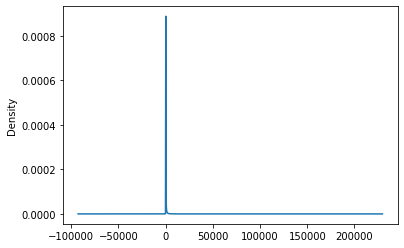

In [ ]:
df['Stock Demand'].plot.kde()

In [ ]:
df['Stock Demand'] = abs(df['Stock Demand'])

In [ ]:
df.describe()

,Stock Demand
count,1048575.0
mean,80.6
std,609.9
min,0.0
25%,3.0
50%,9.0
75%,31.0
max,149004.0


In [ ]:
df = df.groupby('Date')[['Stock Demand']].sum().reset_index()

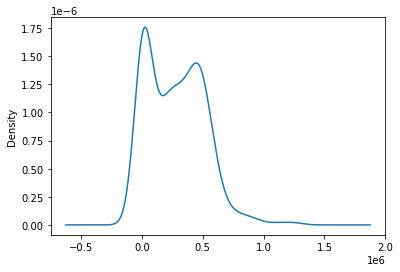

In [ ]:
df['Stock Demand'].plot.kde()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          304 non-null    datetime64[ns]
 1   Stock Demand  304 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.9 KB


##create a new column to get the day name

In [ ]:
df['Dayofweek']=df['Date'].dt.day_name()

In [ ]:
df.groupby('Dayofweek')['Stock Demand'].agg(['mean','count','min','max','sum'])

,mean,count,min,max,sum
Dayofweek,,,,,
Friday,369031.8,44,1705,1118029,16237401
Monday,386667.6,43,21943,943207,16626708
Saturday,37802.4,44,133,500515,1663304
Sunday,15046.9,43,143,29521,647015
Thursday,364650.0,44,44606,768521,16044602
Tuesday,386995.1,43,24017,927720,16640791
Wednesday,387965.7,43,95300,1250165,16682527


## As we see above saturday and sunday has the lowest Stock Demand compare to the rest of days because of the weekends

In [ ]:
df_sorted=df.sort_values(by='Date')

In [ ]:
# we here set date time column as index of data frame
df_sorted = df_sorted.set_index(pd.DatetimeIndex(df_sorted['Date']))

In [ ]:
# show the first five rows
df_sorted.head()

,Date,Stock Demand,Dayofweek
Date,,,
2020-10-01,2020-10-01,186156,Thursday
2020-10-02,2020-10-02,204747,Friday
2020-10-03,2020-10-03,3154,Saturday
2020-10-04,2020-10-04,13719,Sunday
2020-10-05,2020-10-05,255951,Monday


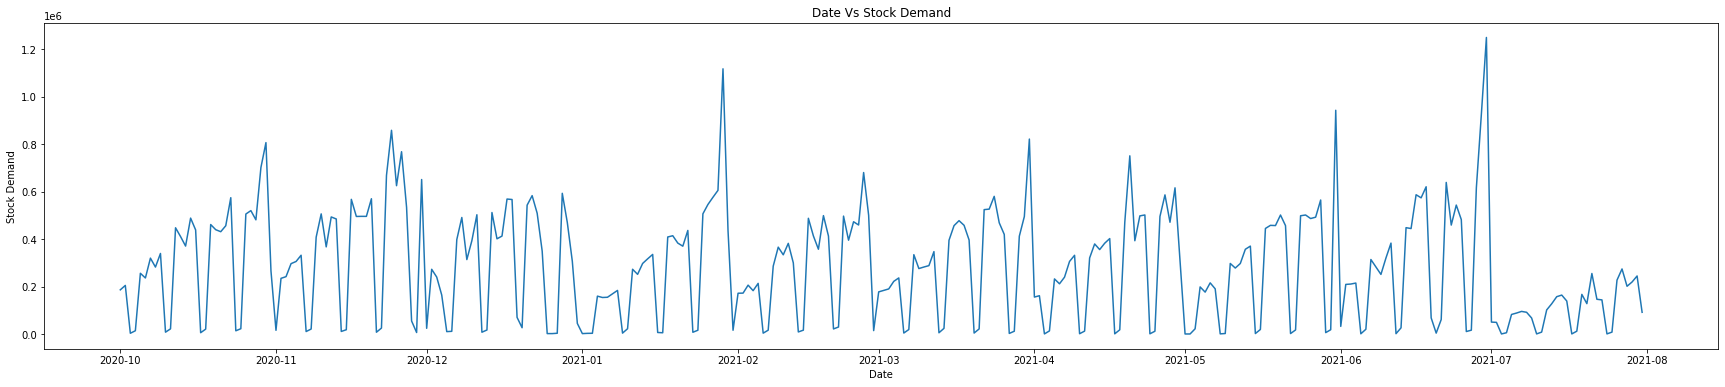

In [ ]:
# plot Date Vs traffic
plt.figure(figsize=(30,6))
plt.plot(df_sorted['Date'],df_sorted['Stock Demand'])
plt.xlabel('Date')
plt.ylabel('Stock Demand')
plt.title('Date Vs Stock Demand')
plt.show()

In [ ]:
portion_df = df_sorted['Stock Demand']
portion_df

Date
2020-10-01    186156
2020-10-02    204747
2020-10-03      3154
2020-10-04     13719
2020-10-05    255951
               ...  
2021-07-27    274250
2021-07-28    201233
2021-07-29    219322
2021-07-30    244653
2021-07-31     91470
Name: Stock Demand, Length: 304, dtype: int64

## split the data into train test in order matter

In [ ]:
split_date = '2021-07-01'
ts_train = portion_df.loc[portion_df.index <= split_date].copy()
ts_test = portion_df.loc[portion_df.index > split_date].copy()

## check this data if stationary or not

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

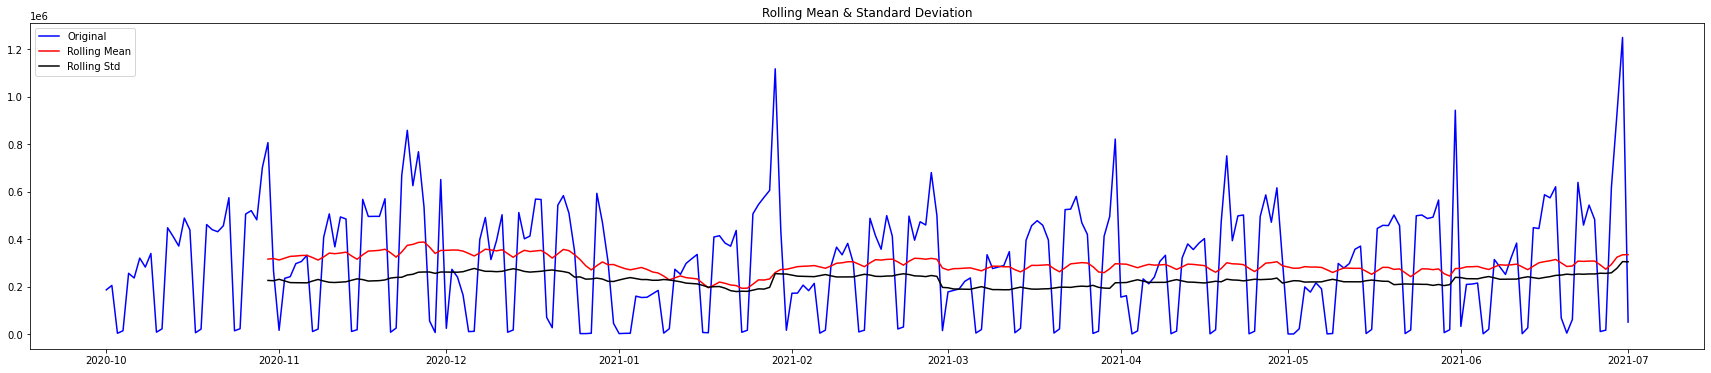

Results of Dickey-Fuller Test:
Test Statistic                 -5.2
p-value                         0.0
#Lags Used                     16.0
Number of Observations Used   257.0
Critical Value (1%)            -3.5
Critical Value (5%)            -2.9
Critical Value (10%)           -2.6
dtype: float64


In [ ]:
test_stationarity(ts_train)

## as we see from the graph above the mean of the data is almost constnant wit time so our data is stationary check this link for more understanding about dickey fuller test https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/

## now we are building ARIMA model so we need to choose the P q d value so d is zero because our data is stationary

In [ ]:
# ACF and PACF plots
lag = 30
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


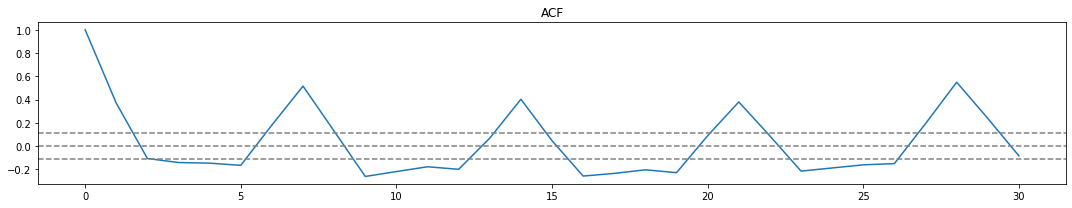

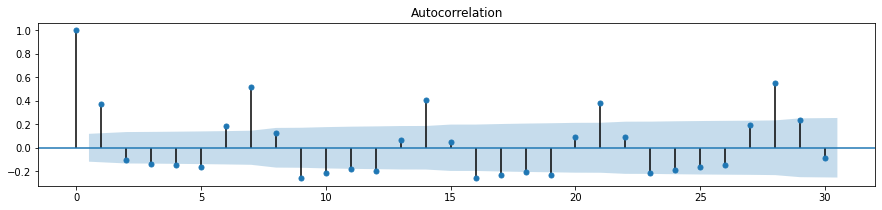

In [ ]:
#Plot ACF auto corrletion function 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train, ax=plt.gca(),lags=lag)
plt.show()

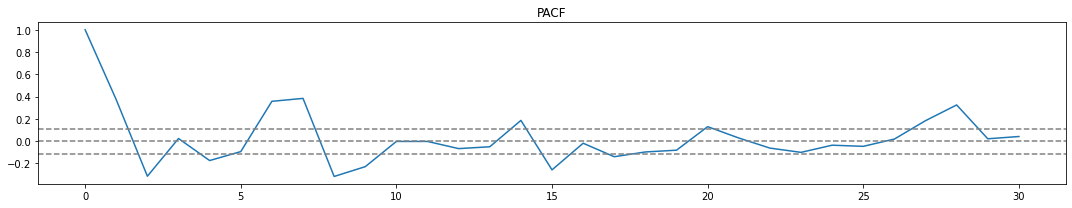

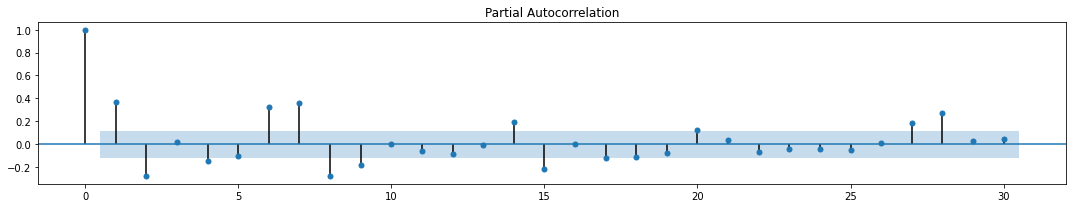

In [ ]:
#Plot PACF partial auto corrletion function
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [ ]:
p=2 # from PACF Curve
q=5 # from ACF Curve
d=0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

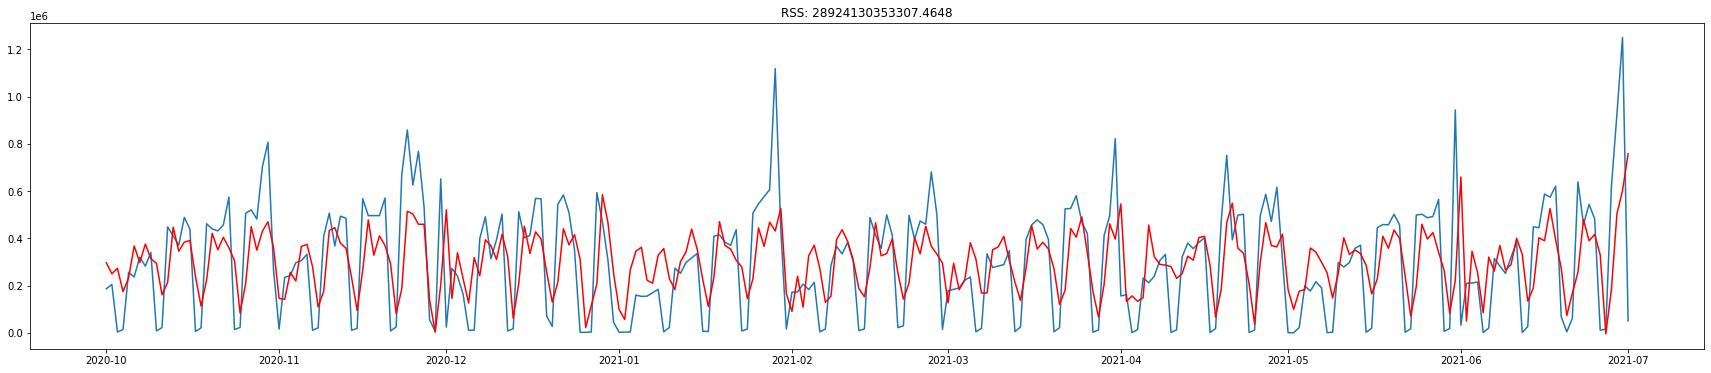

In [ ]:
# ARIMA auto autoregressive integrated moving average
model = ARIMA(ts_train, order=(p, d, q))  
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [ ]:
# summury of our model
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Stock Demand   No. Observations:                  274
Model:                     ARMA(2, 5)   Log Likelihood               -3728.954
Method:                       css-mle   S.D. of innovations         196397.991
Date:                Thu, 29 Sep 2022   AIC                           7475.908
Time:                        09:53:27   BIC                           7508.426
Sample:                    10-01-2020   HQIC                          7488.960
                         - 07-01-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.965e+05   1.36e+04     21.782      0.000     2.7e+05    3.23e+05
ar.L1.Stock Demand     0.5952      0.138      4.308      0.000       0.324       0.866
ar.L2.Stock Demand    -0.6066      0.104     -5.810      0.000      -0.811      -0.402
ma.L1.Stock Demand    -0.1197      0.134     -0.891      0.373      -0.383       0.143
ma.L2.Stock Demand     0.4139      0.091      4.536      0.000       0.235       0.593
ma.L3.Stock Demand     0.1936      0.116      1.665      0.096      -0.034       0.422
ma.L4.Stock Demand    -0.0330      0.133     -0.247      0.805      -0.294       0.228
ma.L5.Stock Demand    -0.2993      0.117     -2.552      0.011      -0.529      -0.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4906           -1.1865j            1.2839           -0.1876
AR.2            0.4906           +1.1865j            1.2839            0.1876
MA.1            0.3091           -1.0085j            1.0548           -0.2027
MA.2            0.3091           +1.0085j            1.0548            0.2027
MA.3            1.4939           -0.0000j            1.4939           -0.0000
MA.4           -1.1111           -0.8808j            1.4179           -0.3933
MA.5           -1.1111           +0.8808j            1.4179            0.3933
-----------------------------------------------------------------------------
"""

## Residual plot

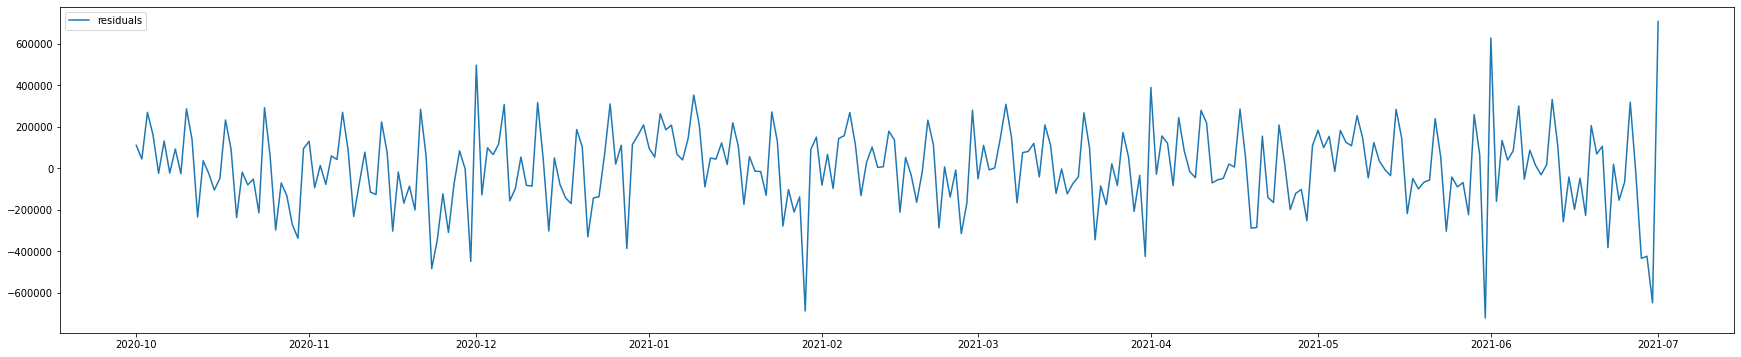

In [ ]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['Stock Demand']
x = x['Stock Demand'] - ts_train
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

## test the ARIMA model on test dataset

In [ ]:
# define function to get perdiction for forecasting
def StartARIMAForecasting(Actual, p, d, q):
	model = ARIMA(Actual, order=(p, d, q))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction

In [ ]:
#new arrays to store actual and predictions
Actual = [x for x in ts_train]
Predictions = list()

In [ ]:
#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test)):
	ActualValue =  ts_test[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 3,1,0)    
	print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	#add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Actual=49066.000000, Predicted=120209.576256
Actual=240.000000, Predicted=505996.819075
Actual=5374.000000, Predicted=193165.215178
Actual=82412.000000, Predicted=22335.095005
Actual=88362.000000, Predicted=71258.260818
Actual=95300.000000, Predicted=55944.898128
Actual=91580.000000, Predicted=80319.245192
Actual=67466.000000, Predicted=88214.842695
Actual=438.000000, Predicted=72005.604307
Actual=8070.000000, Predicted=22488.759234
Actual=101511.000000, Predicted=34839.061093
Actual=127447.000000, Predicted=88818.562088
Actual=157327.000000, Predicted=84594.563631
Actual=164079.000000, Predicted=128151.569021
Actual=139004.000000, Predicted=147411.994293
Actual=353.000000, Predicted=136913.458420
Actual=11909.000000, Predicted=35480.219545
Actual=167026.000000, Predicted=65860.749492
Actual=127961.000000, Predicted=151061.272851
Actual=255112.000000, Predicted=73448.309060
Actual=146415.000000, Predicted=223865.667927
Actual=143839.000000, Predicted=124039.233305
Actual=492.000000, Pr

In [ ]:
# define function calculate Mean Absolute percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#Calculate Model error 1-Mean Absolute Error 2-Root Mean Squared Error 3-Mean Absolute percentage Error
print('Test Mean Absolute Error:', mean_absolute_error(ts_test, predictions))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test, predictions)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test, predictions[0]))

Test Mean Absolute Error: 82057.49966731748
Test Root Mean Squared Error: 126247.07535053696
Test Mean Absolute percentage Error: 10173.98534741326


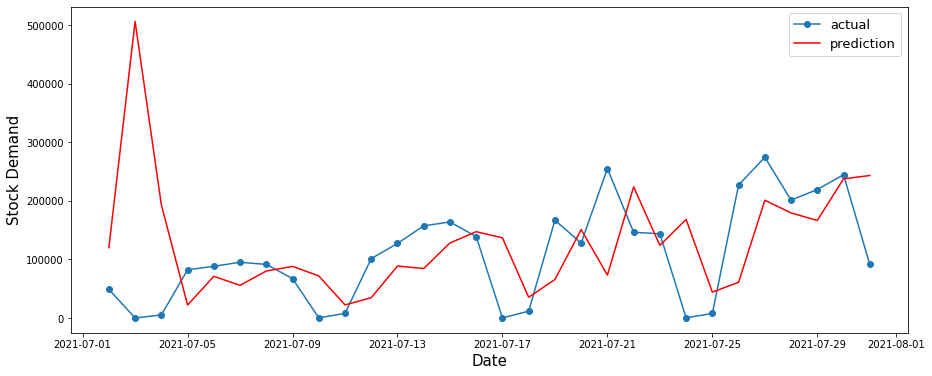

In [ ]:
# plot actual value vs predicted
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, ts_test, marker='o', label="actual")
plt.plot(ts_test.index, Predictions, 'r', label="prediction")
plt.ylabel('Stock Demand', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

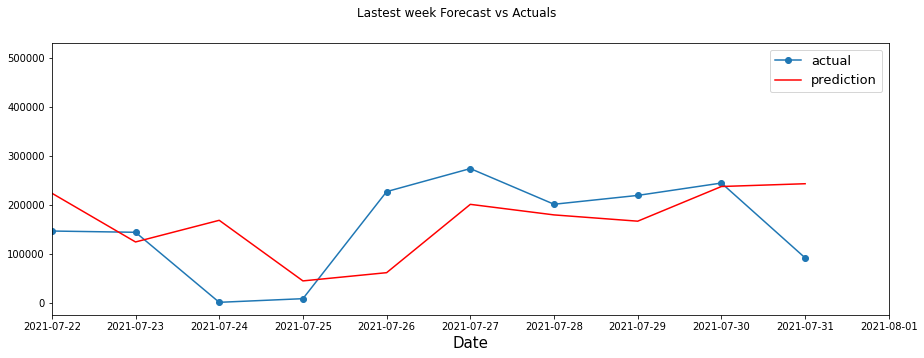

In [ ]:
# zoom on lastest week
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, ts_test, marker='o', label="actual")
plt.plot(ts_test.index, Predictions, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2021,7,22), upper=datetime.date(2021,8,1))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [ ]:
# get the next 30 days of stock
from dateutil.relativedelta import relativedelta
start= datetime.datetime.strptime("2021-07-31","%Y-%m-%d")
date_list=[start + relativedelta(days=x) for x in range(0,31)]
future_predictions=pd.DataFrame(index=date_list,columns=df.columns)

In [ ]:
# concat the test data with the next 8 houre to predict the future data
data=pd.concat([ts_test,future_predictions],axis=0)

In [ ]:
data=data.iloc[:,0]

In [ ]:
data

2021-07-02   49066.0
2021-07-03     240.0
2021-07-04    5374.0
2021-07-05   82412.0
2021-07-06   88362.0
               ...  
2021-08-26       NaN
2021-08-27       NaN
2021-08-28       NaN
2021-08-29       NaN
2021-08-30       NaN
Name: 0, Length: 61, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be use

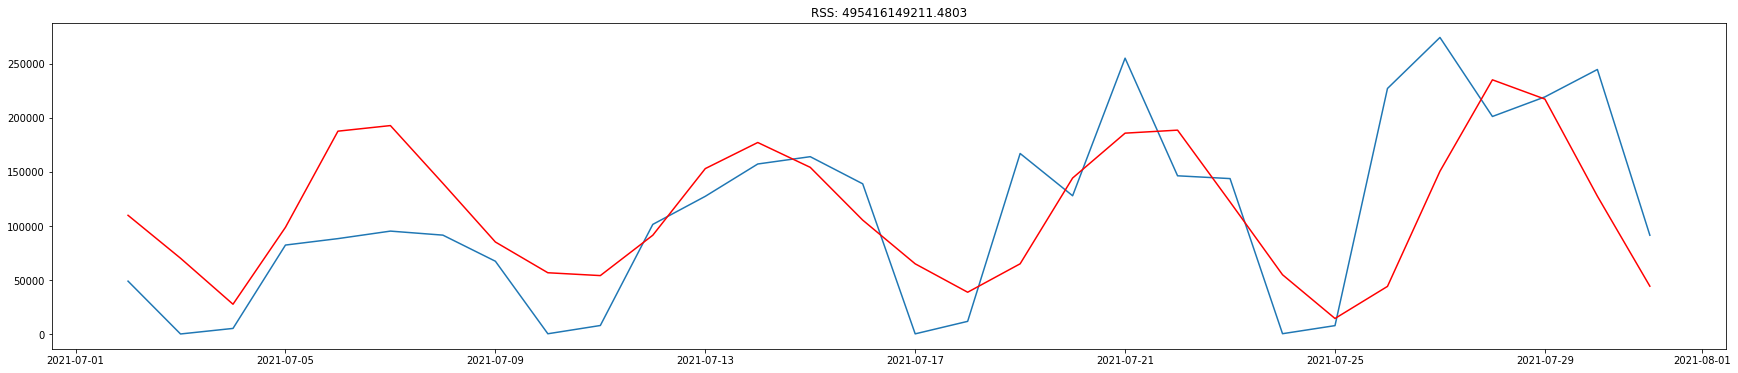

In [ ]:
# ARIMA auto autoregressive integrated moving average
model = ARIMA(ts_test, order=(p, d, 2))  
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_test)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [ ]:
#get prediction of the next month
pred=results_ARIMA.predict(start=len(ts_test),end=len(data)-1,dynamic=True)

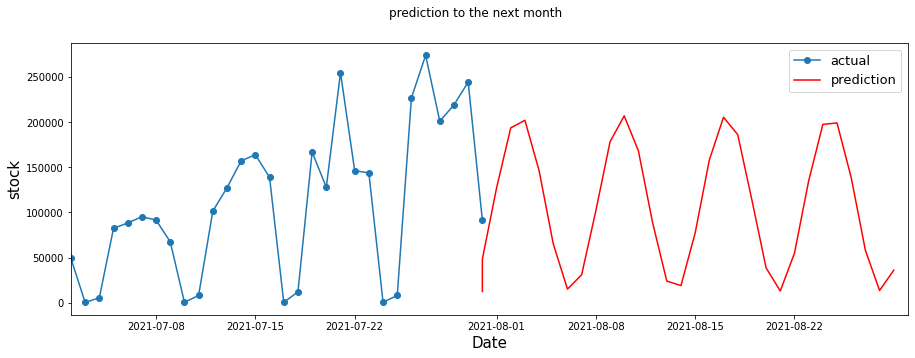

In [ ]:
# plot prediction for next 8 month
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, ts_test, marker='o', label="actual")
plt.plot(data['2021-07-31':'2021-08-29'].index, pred, 'r',label="prediction")
ax.set_xbound(lower= datetime.date(2021,7,2), upper=datetime.date(2021,8,30))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
plt.ylabel('stock',size = 15)
plot = plt.suptitle('prediction to the next month')

In [ ]:
# save future data 
Future ={'Datetime':date_list,'Stock Demand':list(np.array(pred,dtype=int))}

In [ ]:
df_future_nextmonth=pd.DataFrame(Future)
df_future_nextmonth

,Datetime,Stock Demand
0,2021-07-31,12418
1,2021-08-01,48287
2,2021-08-02,127034
3,2021-08-03,193850
4,2021-08-04,202230
5,2021-08-05,146342
6,2021-08-06,65085
7,2021-08-07,15013
8,2021-08-08,30978
9,2021-08-09,101868
